In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [54]:
import numpy as np
from keras.datasets import mnist
from keras.models import Model,Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras import backend as K
import matplotlib.pyplot as plt
import tensorflow as tf
# the data, split between train and test sets
from keras.utils import np_utils
from matplotlib import pyplot
from sklearn.model_selection import KFold
from tensorflow.python.keras import Sequential
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from tensorflow.keras.layers import GaussianNoise
from keras.callbacks import ModelCheckpoint

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
#Defining Dataset
def input_data():
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    # Reshape to be samples*pixels*width*height
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
    X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')

    # One hot Cpde
    y_train = np_utils.to_categorical(y_train)
    y_test = np_utils.to_categorical(y_test)
    num_classes = y_test.shape[1]

    # convert from integers to floats
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    # normalize to range [0, 1]
    X_train = (X_train / 255.0)
    X_test = (X_test / 255.0)

    return X_train, y_train,X_test, y_test

In [5]:
#Adding Noise to training data
def training_noise(X_train):
    sample=GaussianNoise(0.2)

    noisey_X_train=sample(X_train,training=True)

    return noisey_X_train

In [56]:
batch_size=64
epochs=15
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x,y,inChannel ))
num_classes = 10

In [64]:
def encoder(input_img):
    flatten=Flatten(input_shape=(28,28))(input_img)
    layer_1=Dense(512, activation='relu',kernel_initializer="glorot_uniform")(flatten)
    layer_2=Dense(128, activation='relu',kernel_initializer="glorot_uniform")(layer_1)
    layer_3=Dense(16, activation='relu',kernel_initializer="glorot_uniform")(layer_2)
    return layer_3

def decoder(layer_3):
    layer_4=Dense(128, activation='relu',kernel_initializer="glorot_uniform")(layer_3)
    layer_5=Dense(512, activation='relu',kernel_initializer="glorot_uniform")(layer_4)
    layer_6=Dense(784, activation='relu',kernel_initializer="glorot_uniform")(layer_5)
    reshape=Reshape((28,28,1), input_shape=(784,))(layer_6)
    return reshape
    

In [65]:
autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss='mean_squared_error', optimizer = Adam())

In [66]:
autoencoder.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_26 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_27 (Dense)             (None, 16)                2064      
_________________________________________________________________
dense_28 (Dense)             (None, 128)               2176      
_________________________________________________________________
dense_29 (Dense)             (None, 512)               6604

In [67]:
X_train, y_train, X_test, y_test=input_data()

noisy_X_train=training_noise(X_train)

autoencoder_train = autoencoder.fit(noisy_X_train, X_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(X_test,X_test))

Epoch 1/15
938/938 [==============================] - 5s 5ms/step - loss: 0.0390 - val_loss: 0.0202
Epoch 2/15
938/938 [==============================] - 5s 5ms/step - loss: 0.0207 - val_loss: 0.0176
Epoch 3/15
938/938 [==============================] - 5s 5ms/step - loss: 0.0181 - val_loss: 0.0163
Epoch 4/15
938/938 [==============================] - 5s 5ms/step - loss: 0.0169 - val_loss: 0.0156
Epoch 5/15
938/938 [==============================] - 5s 5ms/step - loss: 0.0159 - val_loss: 0.0149
Epoch 6/15
938/938 [==============================] - 5s 5ms/step - loss: 0.0151 - val_loss: 0.0145
Epoch 7/15
938/938 [==============================] - 5s 5ms/step - loss: 0.0147 - val_loss: 0.0143
Epoch 8/15
938/938 [==============================] - 5s 5ms/step - loss: 0.0142 - val_loss: 0.0137
Epoch 9/15
938/938 [==============================] - 5s 5ms/step - loss: 0.0137 - val_loss: 0.0135
Epoch 10/15
938/938 [==============================] - 5s 5ms/step - loss: 0.0135 - val_loss: 0.0132

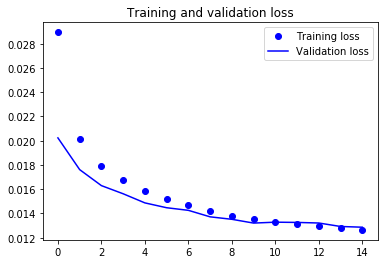

In [68]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(15)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [69]:
autoencoder.save_weights('autoencoder.h5')

In [70]:
#normal neural network

def fc(enco):
    flat = Flatten()(enco)
    den = Dense(128, activation='relu')(flat)
    den=Dropout(0.2)(den)
    out = Dense(num_classes, activation='softmax')(den)
    return out

In [71]:
encode = encoder(input_img)
full_model = Model(input_img,fc(encode))

In [72]:
for l1,l2 in zip(full_model.layers[:4],autoencoder.layers[0:4]):
    l1.set_weights(l2.get_weights())

In [75]:
#Same weights are copied in the second network

if (autoencoder.get_weights()[0][1].all()==full_model.get_weights()[0][1].all()):
    print("True")

True


In [76]:
#stop training of copies layers

for layer in full_model.layers[0:4]:
    layer.trainable = False

In [77]:
full_model.compile(loss="categorical_crossentropy", optimizer=Adam(),metrics=['accuracy'])

In [78]:
full_model.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_32 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_33 (Dense)             (None, 16)                2064      
_________________________________________________________________
flatten_4 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 128)               217

In [79]:
classify_train = full_model.fit(X_train, y_train, batch_size=64,epochs=10,verbose=1,validation_data=(X_test, y_test))

Epoch 1/10
938/938 [==============================] - 5s 5ms/step - loss: 0.8888 - accuracy: 0.7069 - val_loss: 0.2004 - val_accuracy: 0.9412
Epoch 2/10
938/938 [==============================] - 4s 5ms/step - loss: 0.2130 - accuracy: 0.9335 - val_loss: 0.1581 - val_accuracy: 0.9528
Epoch 3/10
938/938 [==============================] - 4s 5ms/step - loss: 0.1696 - accuracy: 0.9470 - val_loss: 0.1272 - val_accuracy: 0.9592
Epoch 4/10
938/938 [==============================] - 4s 5ms/step - loss: 0.1443 - accuracy: 0.9549 - val_loss: 0.1224 - val_accuracy: 0.9622
Epoch 5/10
938/938 [==============================] - 4s 4ms/step - loss: 0.1309 - accuracy: 0.9602 - val_loss: 0.1126 - val_accuracy: 0.9660
Epoch 6/10
938/938 [==============================] - 4s 5ms/step - loss: 0.1236 - accuracy: 0.9617 - val_loss: 0.1071 - val_accuracy: 0.9662
Epoch 7/10
938/938 [==============================] - 4s 4ms/step - loss: 0.1180 - accuracy: 0.9638 - val_loss: 0.1027 - val_accuracy: 0.9681
Epoch 

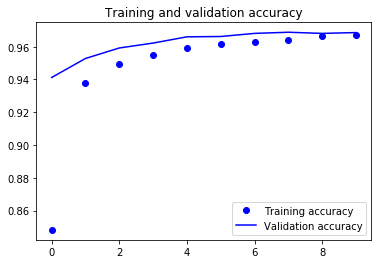

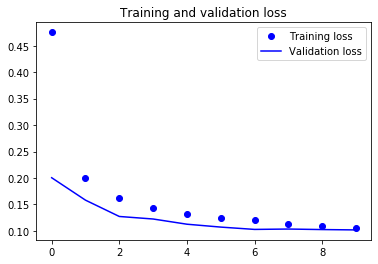

In [80]:
accuracy = classify_train.history['accuracy']
val_accuracy = classify_train.history['val_accuracy']
loss = classify_train.history['loss']
val_loss = classify_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Predicted digit: 7
Predicted digit: 2
Predicted digit: 1
Predicted digit: 0


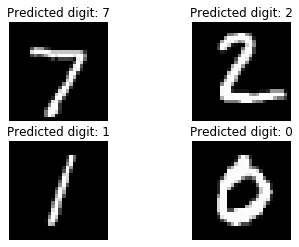

In [82]:

test_images = X_test[0:4]
test_images = test_images.reshape(test_images.shape[0], 28, 28)

for i, test_image in enumerate(test_images, start=1):
    org_image = test_image
    test_image = test_image.reshape(1, 28, 28, 1)
    prediction = np.argmax(full_model.predict(test_image, verbose=0), axis=1)

    print("Predicted digit: {}".format(prediction[0]))
    plt.subplot(220 + i)
    plt.axis('off')
    plt.title("Predicted digit: {}".format(prediction[0]))
    plt.imshow(org_image, cmap=plt.get_cmap('gray'))

plt.show()

In [83]:
import cv2

(28, 28)


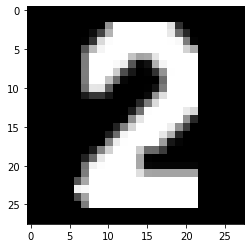

In [90]:
test_image=cv2.imread("D:\RoboSys\Projects\Sudoku Solver\Sudoku Solver Retry\CleanedBoardCells\cell58.png",0)

test_image=cv2.resize(test_image,(28,28))
print(test_image.shape)
plt.imshow(test_image,cmap="gray")

In [91]:
test_image=test_image.reshape(1,28,28,1)
prediction = np.argmax(full_model.predict(test_image, verbose=0), axis=1)
print(prediction)

[2]


In [92]:
full_model.save('classification_complete.h5')